In [3]:
import numpy as np
import pandas as pd
import rebound
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

In [19]:
#sampling interval and tmax
def tmax_and_sample_interval(sim,samples_per_orbit,n_orbits):
    o = sim.calculate_orbits(heliocentric=True)
    return o[0].P/samples_per_orbit, o[0].P*n_orbits*2*np.pi

#get fft
def get_fft(signal,tmax):
    Npts = len(signal)
    fft = np.fft.fft(signal)
    freq = np.fft.fftfreq(Npts, tmax/Npts)
    return freq, fft, np.max(freq)

#remove high freq 
def low_pass(signal,tmax,fcut):
    freq, fft, fmax = get_fft(signal,tmax)
    fft[np.abs(freq) > fcut] = 0
    return np.fft.ifft(fft)

def write(f,sim):
    o = sim.calculate_orbits(heliocentric=True)
    f.write("%e,%e,%e,%e,%e,%e\n"%(sim.t,o[0].P,o[0].a,o[0].e,o[0].omega,o[0].M))

### Generate data

In [20]:
filename='ic0000000.bin'
sim = rebound.Simulation.from_file(filename)
sim.status()

---------------------------------
REBOUND version:     	3.4.0
REBOUND built on:    	May 11 2017 15:14:36
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.034640
---------------------------------
<rebound.Particle object, m=1.0 x=2.15130954841e-05 y=-2.83134950296e-05 z=-3.59702797063e-07 vx=0.000184889789743 vy=0.000118365239205 vz=-2.10835927452e-06>
<rebound.Particle object, m=3.41401601921e-05 x=-0.0658395691021 y=0.997590609731 z=-0.00120070677257 vx=-6.26836429024 vy=-0.445311904669 vz=0.0559526195024>
<rebound.Particle object, m=1.87872497534e-05 x=-1.14094577147 y=-0.203694227095 z=0.0167610663709 vx=1.22970372256 vy=-5.8554285143 vz=-0.0177819457008>
<rebound.Particle object, m=1.82689985991e-06 x=1.18775591557 y=-1.04962177571 z=0.0469652335416 vx=3.28995608402 vy=3.74688214542 vz=0.291314126296>
---------------------------------


/Users/silburt/phd/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [ ]:
samples_per_orbit = 8
n_orbital_periods = 1e5
dt, tmax = tmax_and_sample_interval(sim,samples_per_orbit,n_orbital_periods)
f = open('ic0000000_spo%d.txt'%samples_per_orbit,'w')

write(f,sim)
while sim.t < tmax:
    sim.integrate(sim.t + dt)
    write(f,sim)
write(f,sim)
f.close()

### Analyze Data

In [5]:
filename = 'ic0000000_spo8.txt'
names = ['time','a1','a2','a3','e1','e2','e3','w1','w2','w3','M1','M2','M3']
data = pd.read_csv(filename, names=names)

In [6]:
data.head()

,time,a1,a2,a3,e1,e2,e3,w1,w2,w3,M1,M2,M3
0,0.124998,0.999987,1.221582,1.588890,0.005029,0.059449,0.002448,1.402740,2.311006,1.093191,-0.741398,0.076447,-0.228624
1,0.249996,0.999976,1.221632,1.588907,0.005021,0.059480,0.002458,1.404407,2.311452,1.081831,0.042368,0.657710,0.174849
2,0.374994,0.999970,1.221672,1.588962,0.005012,0.059481,0.002498,1.405069,2.312075,1.077913,0.827150,1.238780,0.570879
3,0.499991,0.999970,1.221696,1.589047,0.005004,0.059454,0.002547,1.405721,2.312403,1.087910,1.611951,1.820136,0.952966
4,0.624989,0.999983,1.221693,1.589149,0.004990,0.059426,0.002576,1.407212,2.312058,1.109788,2.395902,2.402179,1.323137


In [18]:
#FFT vs. sample rate
tmax = 1e5
for i in np.arange(1,9,2):
    freq, fft, fmax = get_fft(data['P1'],tmax)
    

99998.3080687
99998.3080687
99998.3080687
99998.3080687


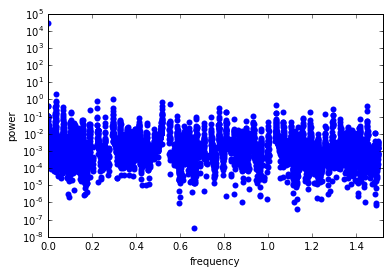

In [14]:
#fft plot
freq, fft, fmax = get_fft(P1,tmax)
plt.plot(freq,fft, 'o', mew=0)
plt.xlim([0,fmax+0.02])
plt.yscale('log');
plt.xlabel('frequency');
plt.ylabel('power');
plt.savefig('images/fft_P1.png')

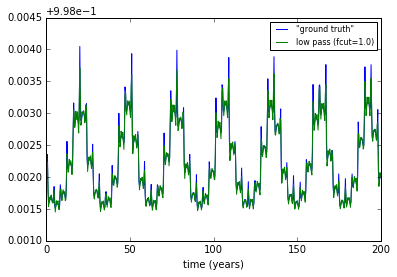

In [7]:
#timeseries plots
fcut = 1
LP = low_pass(P1,tmax,fcut)

t = dt*np.arange(len(P1))
plt.plot(t,P1, label='"ground truth"')
plt.plot(t,LP, label='low pass (fcut=%.1f)'%fcut)
plt.xlabel('time (years)');
plt.legend(fontsize=8)
plt.xlim([0,200])
plt.savefig('images/lowpass_P1.png')

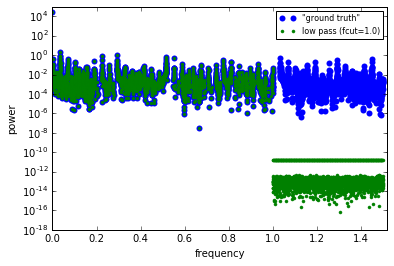

In [12]:
#re-compute FFT of lowpass and compare to original fft
freqLP, fftLP, fmax = get_fft(LP,tmax)
plt.plot(freq,fft, 'o', mew=0, label='"ground truth"')
plt.plot(freqLP,fftLP, '.', label='low pass (fcut=%.1f)'%fcut)
plt.xlim([0,fmax+0.02])
plt.yscale('log');
plt.xlabel('frequency');
plt.ylabel('power');
plt.legend(fontsize=8)
plt.savefig('images/fftcomp_P1.png')